In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

In [4]:
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [5]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

chw_res = pd.read_csv("/content/chw_reserve.csv")
chw_sinfo = pd.read_csv("/content/chw_store_info.csv")
dinfo = pd.read_csv("/content/date_info.csv")
store_rel = pd.read_csv("/content/store_id_relation.csv")
yom_res = pd.read_csv("/content/yom_reserve.csv")
yom_sinfo = pd.read_csv("/content/yom_store_info.csv")

### Matching the Date format in date info and adding date info to the training data

In [6]:
dinfo['calendar_date'] = dinfo.apply(lambda row : datetime.datetime.strptime(row['calendar_date'], '%Y-%m-%d').strftime('%-m/%-d/%Y'), axis=1)

train_df = pd.merge(left = train_df, right = dinfo, left_on = 'visit_date', right_on='calendar_date', how="left")
train_df = pd.merge(left = train_df, right = chw_sinfo, left_on = 'chw_store_id', right_on='chw_store_id', how="left")
train_df[["month", "day", "year"]] = train_df["visit_date"].str.split("/", expand = True)

# train_df['dt'] = pd.to_datetime(train_df['visit_date'])

In [7]:
test_df = pd.merge(left = test_df, right = dinfo, left_on = 'visit_date', right_on='calendar_date', how="left")
test_df = pd.merge(left = test_df, right = chw_sinfo, left_on = 'chw_store_id', right_on='chw_store_id', how="left")
test_df[["month", "day", "year"]] = test_df["visit_date"].str.split("/", expand = True)

# test_df['dt'] = pd.to_datetime(test_df['visit_date'])

In [8]:
train_df.head()

,chw_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year
0,air_3561fd1c0bce6a95,8/25/2016,8,8/25/2016,Thursday,0,Italian/French,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,8,25,2016
1,air_26c5bbeb7bb82bf1,1/11/2017,9,1/11/2017,Wednesday,0,Cafe/Sweets,Tōkyō-to Kita-ku Ōjihonchō,35.752804,139.733480,1,11,2017
2,air_c1ff20617c54fee7,8/10/2016,13,8/10/2016,Wednesday,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171,8,10,2016
3,air_310e467e6e625004,3/10/2017,17,3/10/2017,Friday,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,3,10,2017
4,air_671b4bea84dafb67,6/1/2016,34,6/1/2016,Wednesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,1,2016


### Removing Outliers

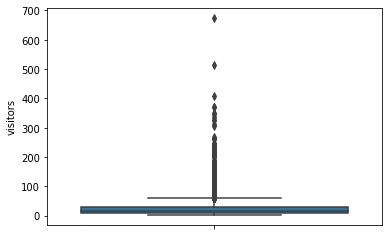

In [9]:
sns.boxplot(data=train_df, y='visitors')

In [10]:
def outliers(df, feat):
  q1 = df[feat].quantile(0.25)
  q3 = df[feat].quantile(0.75)
  iqr = q3-q1
  l = q1 - 2.5*iqr
  r = q3 + 2.5*iqr

  ls = df.index[(df[feat] < l) | (df[feat] > r)]
  return ls

In [11]:
train_df.drop(outliers(train_df, 'visitors'), inplace = True)

In [12]:
train_df['month'] = pd.to_numeric(train_df['month'])
train_df['year'] = pd.to_numeric(train_df['year'])
train_df['day'] = pd.to_numeric(train_df['day'])

In [13]:
test_df['month'] = pd.to_numeric(test_df['month'])
test_df['year'] = pd.to_numeric(test_df['year'])
test_df['day'] = pd.to_numeric(test_df['day'])

In [14]:
train_df['year_bin'] = (train_df['year'] == 2017).astype(int)

In [15]:
test_df['year_bin'] = (test_df['year'] == 2017).astype(int)

In [16]:
# train_df['dt-1'] = train_df['dt']-datetime.timedelta(days=1)
# train_df['dt-2'] = train_df['dt']-datetime.timedelta(days=2)

In [17]:
# test_df['dt-1'] = test_df['dt']-datetime.timedelta(days=1)
# test_df['dt-2'] = test_df['dt']-datetime.timedelta(days=2)

### Adding some new features

In [18]:
# Getting the mean number of visitors for each restaurant and add it as a feature to the train dataset
vismean = train_df.groupby('chw_store_id')['visitors'].agg(['mean', 'min', 'max']).reset_index()
vismean.columns = ['chw_store_id', 'mean_visitors_for_id', 'min_visitors_for_id', 'max_visitors_for_id']

train_df = pd.merge(left = train_df, right = vismean, left_on = 'chw_store_id', right_on = 'chw_store_id', how = 'left')

In [19]:
# Getting the mean number of visitors for each date and add it as a feature to the train dataset
datemean = train_df.groupby('calendar_date')['visitors'].mean().reset_index()
datemean.columns = ['visit_date', 'mean_visitors_for_date']

train_df = pd.merge(left = train_df, right = datemean, left_on = 'visit_date', right_on = 'visit_date', how = 'left')

In [20]:
# Getting the mean number of visitors for each genre and add it as a feature to the train dataset
genremean = train_df.groupby('chw_genre_name')['visitors'].mean().reset_index()
genremean.columns = ['chw_genre_name', 'mean_visitors_for_genre']

train_df = pd.merge(left = train_df, right = genremean, left_on = 'chw_genre_name', right_on = 'chw_genre_name', how = 'left')

In [21]:
# Getting the mean number of visitors for each day of week and add it as a feature to the train dataset
dayOfWeekmean = train_df.groupby('day_of_week')['visitors'].mean().reset_index()
dayOfWeekmean.columns = ['day_of_week', 'mean_visitors_for_dayOfWeek']

train_df = pd.merge(left = train_df, right = dayOfWeekmean, left_on = 'day_of_week', right_on = 'day_of_week', how = 'left')

In [22]:
# Getting the number of restaurants in a particular area and add it as a feature to the train dataset
areaRest = chw_sinfo.groupby('chw_area_name')['chw_store_id'].count().reset_index()
areaRest.columns = ['chw_area_name', 'numberOfRestInArea']

train_df = pd.merge(left = train_df, right = areaRest, left_on = 'chw_area_name', right_on = 'chw_area_name', how = 'left')

In [23]:
# Getting the mean number of visitors for each month of year and add it as a feature to the train dataset
monthmean = train_df.groupby('month')['visitors'].agg(['mean', 'min', 'max']).reset_index()
monthmean.columns = ['month', 'mean_visitors_for_month', 'min_visitors_for_month', 'max_visitors_for_month']

train_df = pd.merge(left = train_df, right = monthmean, left_on = 'month', right_on = 'month', how = 'left')

In [24]:
# Is this a weekend or not?
train_df['is_weekend'] = ((train_df['day_of_week'] == 'Saturday') | (train_df['day_of_week'] == 'Sunday')).astype(int)

In [25]:
# Is this a month end or not?
train_df['is_monthend'] = (train_df['day'] >= 26).astype(int)

In [26]:
# Getting the mean number of visitors for holiday/working day and add it as a feature to the train dataset
holidaymean = train_df.groupby('holiday_flg')['visitors'].mean().reset_index()
holidaymean.columns = ['holiday_flg', 'mean_visitors_for_holiday_flg']

train_df = pd.merge(left = train_df, right = holidaymean, left_on = 'holiday_flg', right_on = 'holiday_flg', how = 'left')

In [27]:
# How was a restuarant performing that month
idmonthmean = train_df.groupby(['chw_store_id', 'month'])['visitors'].mean().reset_index()
idmonthmean.columns = ['chw_store_id', 'month', 'mean_visitors_for_id-month']

train_df = pd.merge(left = train_df, right = idmonthmean, left_on = ['chw_store_id', 'month'], right_on = ['chw_store_id', 'month'], how = 'left')

# How was a restaurant performing that year
idyearmean = train_df.groupby(['chw_store_id', 'year'])['visitors'].mean().reset_index()
idyearmean.columns = ['chw_store_id', 'year', 'mean_visitors_for_id-year']

train_df = pd.merge(left = train_df, right = idyearmean, left_on = ['chw_store_id', 'year'], right_on = ['chw_store_id', 'year'], how = 'left')

# How restaurant performs on a particualar day in week
iddayofweekmean = train_df.groupby(['chw_store_id', 'day_of_week'])['visitors'].mean().reset_index()
iddayofweekmean.columns = ['chw_store_id', 'day_of_week', 'mean_visitors_for_id-day_of_week']

train_df = pd.merge(left = train_df, right = iddayofweekmean, left_on = ['chw_store_id', 'day_of_week'], right_on = ['chw_store_id', 'day_of_week'], how = 'left')



In [28]:
# Number of visitors last two days (if availiable)
# train_df = pd.merge(left = train_df, right = train_df[['chw_store_id', 'dt', 'visitors']], left_on = ['chw_store_id', 'dt-1'], right_on = ['chw_store_id', 'dt'], how='left', suffixes=('', '_onedayback'))
# train_df = pd.merge(left = train_df, right = train_df[['chw_store_id', 'dt', 'visitors']], left_on = ['chw_store_id', 'dt-2'], right_on = ['chw_store_id', 'dt'], how='left', suffixes=('', '_twodaysback'))


In [29]:
train_df.head()

,chw_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year,year_bin,mean_visitors_for_id,min_visitors_for_id,max_visitors_for_id,mean_visitors_for_date,mean_visitors_for_genre,mean_visitors_for_dayOfWeek,numberOfRestInArea,mean_visitors_for_month,min_visitors_for_month,max_visitors_for_month,is_weekend,is_monthend,mean_visitors_for_holiday_flg,mean_visitors_for_id-month,mean_visitors_for_id-year,mean_visitors_for_id-day_of_week
0,air_3561fd1c0bce6a95,8/25/2016,8,8/25/2016,Thursday,0,Italian/French,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,8,25,2016,0,15.656069,1,40,18.498408,22.013566,18.632466,4,19.435520,1,79,0,0,20.309805,14.826087,16.670290,8.140351
1,air_26c5bbeb7bb82bf1,1/11/2017,9,1/11/2017,Wednesday,0,Cafe/Sweets,Tōkyō-to Kita-ku Ōjihonchō,35.752804,139.733480,1,11,2017,1,27.223602,1,64,16.341346,21.796145,19.010131,2,19.519722,1,79,0,0,20.309805,23.000000,29.924242,22.482143
2,air_c1ff20617c54fee7,8/10/2016,13,8/10/2016,Wednesday,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171,8,10,2016,0,8.011834,1,21,23.436817,22.600522,19.010131,22,19.435520,1,79,0,0,20.309805,6.761905,8.225000,7.384615
3,air_310e467e6e625004,3/10/2017,17,3/10/2017,Friday,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,3,10,2017,1,14.618785,2,35,23.924309,22.013566,22.581894,29,21.627583,1,79,0,0,20.309805,16.380952,15.086207,17.852941
4,air_671b4bea84dafb67,6/1/2016,34,6/1/2016,Wednesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,1,2016,0,24.621359,7,60,18.365759,19.241293,19.010131,51,20.869961,1,79,0,0,20.309805,22.964286,24.033133,25.180328


In [30]:
# Doing all the above for test_df

# Getting the mean number of visitors for each restaurant and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = vismean, left_on = 'chw_store_id', right_on = 'chw_store_id', how = 'left')

# Getting the mean number of visitors for each date and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = datemean, left_on = 'visit_date', right_on = 'visit_date', how = 'left')

# Getting the mean number of visitors for each genre and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = genremean, left_on = 'chw_genre_name', right_on = 'chw_genre_name', how = 'left')

# Getting the mean number of visitors for each day of week and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = dayOfWeekmean, left_on = 'day_of_week', right_on = 'day_of_week', how = 'left')

# Getting the number of restaurants in a particular area and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = areaRest, left_on = 'chw_area_name', right_on = 'chw_area_name', how = 'left')

# Getting the mean number of visitors for each month of year and add it as a feature to the train dataset
test_df = pd.merge(left = test_df, right = monthmean, left_on = 'month', right_on = 'month', how = 'left')

# Is this a weekend or not?
test_df['is_weekend'] = ((test_df['day_of_week'] == 'Saturday') | (test_df['day_of_week'] == 'Sunday')).astype(int)

# Is this a month end or not?
test_df['is_monthend'] = (test_df['day'] >= 26).astype(int)

# Getting the mean number of visitors for holiday/working day and add it as a feature to the train dataset
holidaymean = train_df.groupby('holiday_flg')['visitors'].mean().reset_index()
holidaymean.columns = ['holiday_flg', 'mean_visitors_for_holiday_flg']

test_df = pd.merge(left = test_df, right = holidaymean, left_on = 'holiday_flg', right_on = 'holiday_flg', how = 'left')

# How was a restuarant performing that month
test_df = pd.merge(left = test_df, right = idmonthmean, left_on = ['chw_store_id', 'month'], right_on = ['chw_store_id', 'month'], how = 'left')

# How was a restaurant performing that year
test_df = pd.merge(left = test_df, right = idyearmean, left_on = ['chw_store_id', 'year'], right_on = ['chw_store_id', 'year'], how = 'left')

test_df = pd.merge(left = test_df, right = iddayofweekmean, left_on = ['chw_store_id', 'day_of_week'], right_on = ['chw_store_id', 'day_of_week'], how = 'left')

# test_df = pd.merge(left = test_df, right = train_df[['chw_store_id', 'dt', 'visitors']], left_on = ['chw_store_id', 'dt-1'], right_on = ['chw_store_id', 'dt'], how='left', suffixes=('', '_onedayback'))
# test_df = pd.merge(left = test_df, right = train_df[['chw_store_id', 'dt', 'visitors']], left_on = ['chw_store_id', 'dt-2'], right_on = ['chw_store_id', 'dt'], how='left', suffixes=('', '_twodaysback'))
# test_df.rename(columns = {'visitors':'visitors_onedayback'}, inplace=True)

In [31]:
test_df.head()

,chw_store_id,visit_date,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year,year_bin,mean_visitors_for_id,min_visitors_for_id,max_visitors_for_id,mean_visitors_for_date,mean_visitors_for_genre,mean_visitors_for_dayOfWeek,numberOfRestInArea,mean_visitors_for_month,min_visitors_for_month,max_visitors_for_month,is_weekend,is_monthend,mean_visitors_for_holiday_flg,mean_visitors_for_id-month,mean_visitors_for_id-year,mean_visitors_for_id-day_of_week
0,air_e7d2ac6d53d1b744,12/9/2016,12/9/2016,Friday,0,Cafe/Sweets,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,12,9,2016,0,14.954984,1.0,40.0,25.152542,21.796145,22.581894,21,22.278107,1,79,0,0,20.309805,13.333333,15.015810,12.452830
1,air_55c3627912b9c849,2/1/2016,2/1/2016,Monday,0,Italian/French,Fukuoka-ken Fukuoka-shi Hakata Ekimae,33.591358,130.414878,2,1,2016,0,12.638404,1.0,38.0,16.542289,22.013566,17.037254,16,20.133963,1,79,0,0,20.309805,12.120000,12.567398,7.509434
2,air_d1418d6fd6d634f2,9/16/2016,9/16/2016,Friday,0,Izakaya,Hyōgo-ken Kōbe-shi Motomachidōri,34.688241,135.187254,9,16,2016,0,18.858369,1.0,55.0,21.211594,22.600522,22.581894,2,19.562540,1,79,0,0,20.309805,16.863636,21.400000,24.888889
3,air_88ca84051ba95339,1/19/2016,1/19/2016,Tuesday,0,Japanese food,Tōkyō-to Shinagawa-ku Hiromachi,35.609226,139.730186,1,19,2016,0,31.287834,1.0,76.0,16.198347,19.241293,17.512050,5,19.519722,1,79,0,0,20.309805,24.609756,34.872180,30.518519
4,air_4d71826793c09b22,1/10/2017,1/10/2017,Tuesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,10,2017,1,22.226277,6.0,49.0,15.544702,19.241293,17.512050,51,19.519722,1,79,0,0,20.309805,22.533333,24.629630,20.183333


In [32]:
# train_df.drop(axis='columns', labels=['dt_onedayback', 'dt', 'dt-1'], inplace=True)
# test_df.drop(axis='columns', labels=['dt_onedayback', 'dt', 'dt-1'], inplace=True)

### Attempt to add some reserve information to the train dataset

In [33]:
train_res = train_df

In [34]:
# Add the corresponding yomato restaurant to a chwiggy restaurant (if any)
train_res = pd.merge(left = train_res, right = store_rel, left_on = 'chw_store_id', right_on = 'chw_store_id', how='left')

In [35]:
def dsplitfun(dtval):
    return dtval.split()[0]
    
# Getting the date column out
chw_res['visit_date'] = chw_res['visit_datetime'].apply(dsplitfun)
yom_res['visit_date'] = yom_res['visit_datetime'].apply(dsplitfun)

# Getting hourly reservations sum
chw_datewise = chw_res.groupby(['chw_store_id','visit_date'])['reserve_visitors'].sum().reset_index()
yom_datewise = yom_res.groupby(['yom_store_id','visit_date'])['reserve_visitors'].sum().reset_index()

In [36]:
chw_datewise.head()

,chw_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,10/31/2016,2
1,air_00a91d42b08b08d9,12/14/2016,18
2,air_00a91d42b08b08d9,12/17/2016,2
3,air_00a91d42b08b08d9,12/20/2016,4
4,air_00a91d42b08b08d9,12/5/2016,9


In [37]:
train_res = pd.merge(left = train_res, right = chw_datewise, left_on = ['chw_store_id', 'visit_date'], right_on = ['chw_store_id', 'visit_date'], how = 'left')
train_res = pd.merge(left = train_res, right = yom_datewise, left_on = ['yom_store_id', 'visit_date'], right_on = ['yom_store_id', 'visit_date'], how = 'left')

In [38]:
train_res.head()

,chw_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year,year_bin,mean_visitors_for_id,min_visitors_for_id,max_visitors_for_id,mean_visitors_for_date,mean_visitors_for_genre,mean_visitors_for_dayOfWeek,numberOfRestInArea,mean_visitors_for_month,min_visitors_for_month,max_visitors_for_month,is_weekend,is_monthend,mean_visitors_for_holiday_flg,mean_visitors_for_id-month,mean_visitors_for_id-year,mean_visitors_for_id-day_of_week,yom_store_id,reserve_visitors_x,reserve_visitors_y
0,air_3561fd1c0bce6a95,8/25/2016,8,8/25/2016,Thursday,0,Italian/French,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,8,25,2016,0,15.656069,1,40,18.498408,22.013566,18.632466,4,19.435520,1,79,0,0,20.309805,14.826087,16.670290,8.140351,NaN,NaN,NaN
1,air_26c5bbeb7bb82bf1,1/11/2017,9,1/11/2017,Wednesday,0,Cafe/Sweets,Tōkyō-to Kita-ku Ōjihonchō,35.752804,139.733480,1,11,2017,1,27.223602,1,64,16.341346,21.796145,19.010131,2,19.519722,1,79,0,0,20.309805,23.000000,29.924242,22.482143,NaN,NaN,NaN
2,air_c1ff20617c54fee7,8/10/2016,13,8/10/2016,Wednesday,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171,8,10,2016,0,8.011834,1,21,23.436817,22.600522,19.010131,22,19.435520,1,79,0,0,20.309805,6.761905,8.225000,7.384615,hpg_4be4a5cb851e45af,NaN,NaN
3,air_310e467e6e625004,3/10/2017,17,3/10/2017,Friday,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,3,10,2017,1,14.618785,2,35,23.924309,22.013566,22.581894,29,21.627583,1,79,0,0,20.309805,16.380952,15.086207,17.852941,NaN,NaN,NaN
4,air_671b4bea84dafb67,6/1/2016,34,6/1/2016,Wednesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,1,2016,0,24.621359,7,60,18.365759,19.241293,19.010131,51,20.869961,1,79,0,0,20.309805,22.964286,24.033133,25.180328,NaN,NaN,NaN


In [39]:
# train_res.rename(columns = {'reserve_visitors_x' : 'resVisitors_perChwRestaurant_forDate', 'reserve_visitors_y' : 'resVisitors_perYomRestaurant_forDate'}, inplace = True)
# train_res.head()

train_res.fillna(0, inplace=True)
train_res['reserve_visitors'] = train_res['reserve_visitors_x'] + train_res['reserve_visitors_y']
train_res.drop(axis='columns', labels=['reserve_visitors_x', 'reserve_visitors_y'], inplace=True)
train_res.head()

,chw_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year,year_bin,mean_visitors_for_id,min_visitors_for_id,max_visitors_for_id,mean_visitors_for_date,mean_visitors_for_genre,mean_visitors_for_dayOfWeek,numberOfRestInArea,mean_visitors_for_month,min_visitors_for_month,max_visitors_for_month,is_weekend,is_monthend,mean_visitors_for_holiday_flg,mean_visitors_for_id-month,mean_visitors_for_id-year,mean_visitors_for_id-day_of_week,yom_store_id,reserve_visitors
0,air_3561fd1c0bce6a95,8/25/2016,8,8/25/2016,Thursday,0,Italian/French,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,8,25,2016,0,15.656069,1,40,18.498408,22.013566,18.632466,4,19.435520,1,79,0,0,20.309805,14.826087,16.670290,8.140351,0,0.0
1,air_26c5bbeb7bb82bf1,1/11/2017,9,1/11/2017,Wednesday,0,Cafe/Sweets,Tōkyō-to Kita-ku Ōjihonchō,35.752804,139.733480,1,11,2017,1,27.223602,1,64,16.341346,21.796145,19.010131,2,19.519722,1,79,0,0,20.309805,23.000000,29.924242,22.482143,0,0.0
2,air_c1ff20617c54fee7,8/10/2016,13,8/10/2016,Wednesday,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171,8,10,2016,0,8.011834,1,21,23.436817,22.600522,19.010131,22,19.435520,1,79,0,0,20.309805,6.761905,8.225000,7.384615,hpg_4be4a5cb851e45af,0.0
3,air_310e467e6e625004,3/10/2017,17,3/10/2017,Friday,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,3,10,2017,1,14.618785,2,35,23.924309,22.013566,22.581894,29,21.627583,1,79,0,0,20.309805,16.380952,15.086207,17.852941,0,0.0
4,air_671b4bea84dafb67,6/1/2016,34,6/1/2016,Wednesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,1,2016,0,24.621359,7,60,18.365759,19.241293,19.010131,51,20.869961,1,79,0,0,20.309805,22.964286,24.033133,25.180328,0,0.0


In [40]:
# Applying all the above to test dataset
test_res = test_df

# Add the corresponding yomato restaurant to a chwiggy restaurant (if any)
test_res = pd.merge(left = test_res, right = store_rel, left_on = 'chw_store_id', right_on = 'chw_store_id', how='left')

def dsplitfun(dtval):
    return dtval.split()[0]
    
# Getting the date column out
chw_res['visit_date'] = chw_res['visit_datetime'].apply(dsplitfun)
yom_res['visit_date'] = yom_res['visit_datetime'].apply(dsplitfun)

# Getting hourly reservations sum
chw_datewise = chw_res.groupby(['chw_store_id','visit_date'])['reserve_visitors'].sum().reset_index()
yom_datewise = yom_res.groupby(['yom_store_id','visit_date'])['reserve_visitors'].sum().reset_index()

test_res = pd.merge(left = test_res, right = chw_datewise, left_on = ['chw_store_id', 'visit_date'], right_on = ['chw_store_id', 'visit_date'], how = 'left')
test_res = pd.merge(left = test_res, right = yom_datewise, left_on = ['yom_store_id', 'visit_date'], right_on = ['yom_store_id', 'visit_date'], how = 'left')

test_res.fillna(0, inplace=True)
test_res['reserve_visitors'] = test_res['reserve_visitors_x'] + test_res['reserve_visitors_y']
test_res.drop(axis='columns', labels=['reserve_visitors_x', 'reserve_visitors_y'], inplace=True)


#### Extracting Genre and area reserve information from chw_reserve

In [41]:
# Getting the mean number of reserve_visitors for each restaurant and add it as a feature to the train dataset
vismean = train_res.groupby('chw_store_id')['reserve_visitors'].agg(['mean', 'min', 'max']).reset_index()
vismean.columns = ['chw_store_id', 'mean_reserve_visitors_for_id', 'min_reserve_visitors_for_id', 'max_reserve_visitors_for_id']

train_res = pd.merge(left = train_res, right = vismean, left_on = 'chw_store_id', right_on = 'chw_store_id', how = 'left')

# Getting the mean number of reserve_visitors for each date and add it as a feature to the train dataset
datemean = train_res.groupby('calendar_date')['reserve_visitors'].mean().reset_index()
datemean.columns = ['visit_date', 'mean_reserve_visitors_for_date']

train_res = pd.merge(left = train_res, right = datemean, left_on = 'visit_date', right_on = 'visit_date', how = 'left')

# Getting the mean number of reserve_visitors for each genre and add it as a feature to the train dataset
genremean = train_res.groupby('chw_genre_name')['reserve_visitors'].mean().reset_index()
genremean.columns = ['chw_genre_name', 'mean_reserve_visitors_for_genre']

train_res = pd.merge(left = train_res, right = genremean, left_on = 'chw_genre_name', right_on = 'chw_genre_name', how = 'left')

# Getting the mean number of reserve_visitors for each day of week and add it as a feature to the train dataset
dayOfWeekmean = train_res.groupby('day_of_week')['reserve_visitors'].mean().reset_index()
dayOfWeekmean.columns = ['day_of_week', 'mean_reserve_visitors_for_dayOfWeek']

train_res = pd.merge(left = train_res, right = dayOfWeekmean, left_on = 'day_of_week', right_on = 'day_of_week', how = 'left')

# Getting the mean number of reserve_visitors for each month of year and add it as a feature to the train dataset
monthmean = train_res.groupby('month')['reserve_visitors'].agg(['mean', 'min', 'max']).reset_index()
monthmean.columns = ['month', 'mean_reserve_visitors_for_month', 'min_reserve_visitors_for_month', 'max_reserve_visitors_for_month']

train_res = pd.merge(left = train_res, right = monthmean, left_on = 'month', right_on = 'month', how = 'left')

# Getting the mean number of reserve_visitors for holiday/working day and add it as a feature to the train dataset
holidaymean = train_res.groupby('holiday_flg')['reserve_visitors'].mean().reset_index()
holidaymean.columns = ['holiday_flg', 'mean_reserve_visitors_for_holiday_flg']

train_res = pd.merge(left = train_res, right = holidaymean, left_on = 'holiday_flg', right_on = 'holiday_flg', how = 'left')


In [42]:
train_res.head()

,chw_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,chw_genre_name,chw_area_name,latitude,longitude,month,day,year,year_bin,mean_visitors_for_id,min_visitors_for_id,max_visitors_for_id,mean_visitors_for_date,mean_visitors_for_genre,mean_visitors_for_dayOfWeek,numberOfRestInArea,mean_visitors_for_month,min_visitors_for_month,max_visitors_for_month,is_weekend,is_monthend,mean_visitors_for_holiday_flg,mean_visitors_for_id-month,mean_visitors_for_id-year,mean_visitors_for_id-day_of_week,yom_store_id,reserve_visitors,mean_reserve_visitors_for_id,min_reserve_visitors_for_id,max_reserve_visitors_for_id,mean_reserve_visitors_for_date,mean_reserve_visitors_for_genre,mean_reserve_visitors_for_dayOfWeek,mean_reserve_visitors_for_month,min_reserve_visitors_for_month,max_reserve_visitors_for_month,mean_reserve_visitors_for_holiday_flg
0,air_3561fd1c0bce6a95,8/25/2016,8,8/25/2016,Thursday,0,Italian/French,Tōkyō-to Ōta-ku Kamiikedai,35.602201,139.697689,8,25,2016,0,15.656069,1,40,18.498408,22.013566,18.632466,4,19.435520,1,79,0,0,20.309805,14.826087,16.670290,8.140351,0,0.0,0.000000,0.0,0.0,0.186306,2.377949,1.339799,0.273900,0.0,39.0,1.597776
1,air_26c5bbeb7bb82bf1,1/11/2017,9,1/11/2017,Wednesday,0,Cafe/Sweets,Tōkyō-to Kita-ku Ōjihonchō,35.752804,139.733480,1,11,2017,1,27.223602,1,64,16.341346,21.796145,19.010131,2,19.519722,1,79,0,0,20.309805,23.000000,29.924242,22.482143,0,0.0,0.000000,0.0,0.0,1.381410,0.243751,1.386120,2.017466,0.0,466.0,1.597776
2,air_c1ff20617c54fee7,8/10/2016,13,8/10/2016,Wednesday,0,Izakaya,Tōkyō-to Meguro-ku Kamimeguro,35.641463,139.698171,8,10,2016,0,8.011834,1,21,23.436817,22.600522,19.010131,22,19.435520,1,79,0,0,20.309805,6.761905,8.225000,7.384615,hpg_4be4a5cb851e45af,0.0,0.343195,0.0,16.0,0.397816,2.722544,1.386120,0.273900,0.0,39.0,1.597776
3,air_310e467e6e625004,3/10/2017,17,3/10/2017,Friday,0,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,3,10,2017,1,14.618785,2,35,23.924309,22.013566,22.581894,29,21.627583,1,79,0,0,20.309805,16.380952,15.086207,17.852941,0,0.0,0.000000,0.0,0.0,3.502183,2.377949,2.291900,2.540642,0.0,142.0,1.597776
4,air_671b4bea84dafb67,6/1/2016,34,6/1/2016,Wednesday,0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,1,2016,0,24.621359,7,60,18.365759,19.241293,19.010131,51,20.869961,1,79,0,0,20.309805,22.964286,24.033133,25.180328,0,0.0,0.000000,0.0,0.0,0.540856,2.202542,1.386120,0.816072,0.0,60.0,1.597776


In [43]:
test_res = pd.merge(left = test_res, right = vismean, left_on = 'chw_store_id', right_on = 'chw_store_id', how = 'left')
test_res = pd.merge(left = test_res, right = datemean, left_on = 'visit_date', right_on = 'visit_date', how = 'left')
test_res = pd.merge(left = test_res, right = genremean, left_on = 'chw_genre_name', right_on = 'chw_genre_name', how = 'left')
test_res = pd.merge(left = test_res, right = dayOfWeekmean, left_on = 'day_of_week', right_on = 'day_of_week', how = 'left')
test_res = pd.merge(left = test_res, right = monthmean, left_on = 'month', right_on = 'month', how = 'left')
test_res = pd.merge(left = test_res, right = holidaymean, left_on = 'holiday_flg', right_on = 'holiday_flg', how = 'left')

In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
train_data = train_res.drop(labels = 'yom_store_id', axis = 'columns')
train_data.fillna(0, inplace=True)
train_data = pd.get_dummies(train_data, columns=['day_of_week', 'chw_genre_name', 'chw_area_name'], drop_first=True)

In [46]:
ler = LabelEncoder()
train_data['chw_store_id'] = ler.fit_transform(train_data['chw_store_id'])

In [47]:
train_data.columns = train_data.columns.str.replace(' ', '_')

In [48]:
train_data.drop(labels=['visit_date', 'calendar_date'], axis='columns', inplace=True)

In [49]:
# Doing the same with test dataset
test_data = test_res.drop(labels = 'yom_store_id', axis = 'columns')
test_data.fillna(0, inplace=True)
test_data = pd.get_dummies(test_data, columns=['day_of_week', 'chw_genre_name', 'chw_area_name'], drop_first=True)

ler = LabelEncoder()
test_data['chw_store_id'] = ler.fit_transform(test_data['chw_store_id'])

test_data.columns = test_data.columns.str.replace(' ', '_')

test_data.drop(labels=['visit_date', 'calendar_date'], axis='columns', inplace=True)

In [50]:
coltr = list(train_data.columns)
coltr.remove('visitors')
print(coltr)

['chw_store_id', 'holiday_flg', 'latitude', 'longitude', 'month', 'day', 'year', 'year_bin', 'mean_visitors_for_id', 'min_visitors_for_id', 'max_visitors_for_id', 'mean_visitors_for_date', 'mean_visitors_for_genre', 'mean_visitors_for_dayOfWeek', 'numberOfRestInArea', 'mean_visitors_for_month', 'min_visitors_for_month', 'max_visitors_for_month', 'is_weekend', 'is_monthend', 'mean_visitors_for_holiday_flg', 'mean_visitors_for_id-month', 'mean_visitors_for_id-year', 'mean_visitors_for_id-day_of_week', 'reserve_visitors', 'mean_reserve_visitors_for_id', 'min_reserve_visitors_for_id', 'max_reserve_visitors_for_id', 'mean_reserve_visitors_for_date', 'mean_reserve_visitors_for_genre', 'mean_reserve_visitors_for_dayOfWeek', 'mean_reserve_visitors_for_month', 'min_reserve_visitors_for_month', 'max_reserve_visitors_for_month', 'mean_reserve_visitors_for_holiday_flg', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_W

In [51]:
coltes = list(test_data.columns)
print(coltes)

['chw_store_id', 'holiday_flg', 'latitude', 'longitude', 'month', 'day', 'year', 'year_bin', 'mean_visitors_for_id', 'min_visitors_for_id', 'max_visitors_for_id', 'mean_visitors_for_date', 'mean_visitors_for_genre', 'mean_visitors_for_dayOfWeek', 'numberOfRestInArea', 'mean_visitors_for_month', 'min_visitors_for_month', 'max_visitors_for_month', 'is_weekend', 'is_monthend', 'mean_visitors_for_holiday_flg', 'mean_visitors_for_id-month', 'mean_visitors_for_id-year', 'mean_visitors_for_id-day_of_week', 'reserve_visitors', 'mean_reserve_visitors_for_id', 'min_reserve_visitors_for_id', 'max_reserve_visitors_for_id', 'mean_reserve_visitors_for_date', 'mean_reserve_visitors_for_genre', 'mean_reserve_visitors_for_dayOfWeek', 'mean_reserve_visitors_for_month', 'min_reserve_visitors_for_month', 'max_reserve_visitors_for_month', 'mean_reserve_visitors_for_holiday_flg', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_W

In [52]:
np.array(coltr) == np.array(coltes)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,


<br>

In [53]:
def dosplit(df, fcols, targetcol):
    X = df.loc[:, fcols]
    y = df[targetcol]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20, random_state=3)
    return (X_train, X_test, y_train, y_test)

def rmlse(y_test, yhat_test):
    return np.sqrt(((np.log(y_test+1)-np.log(yhat_test+1))**2).mean())

In [54]:
totcols = list(train_data.columns)
targcol = 'visitors'
featcol = [ccol for ccol in totcols if ccol != targcol]

#### Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = dosplit(train_data, featcol, targcol)

In [65]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [66]:
yhat_test = lr_model.predict(X_test)
rmlse(y_test, yhat_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


0.49979098854697046

####Lasso Regression

In [67]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha =0.0005)
# rmse_cv(lasso)

In [68]:
lasso.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.317e+06, tolerance: 3.847e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.0005)

In [69]:
yhat_test = lasso.predict(X_test)
rmlse(y_test, yhat_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


0.4990591497783832

In [70]:
X_te = test_data

In [71]:
y_te = lasso.predict(X_te)

In [72]:
y_te

array([11.43771674,  6.40225964, 23.72400968, ..., 37.83397684,
       22.67115619,  7.03136028])

In [73]:
samp_sub_lasso = pd.read_csv("/content/sample_submission.csv")

In [74]:
samp_sub_lasso['visitors'] = y_te

In [75]:
samp_sub_lasso

,id,visitors
0,air_e7d2ac6d53d1b744_12/9/2016,11.437717
1,air_55c3627912b9c849_2/1/2016,6.402260
2,air_d1418d6fd6d634f2_9/16/2016,23.724010
3,air_88ca84051ba95339_1/19/2016,25.924481
4,air_4d71826793c09b22_1/10/2017,20.573495
...,...,...
23963,air_f6cdaf7b7fdc6d78_1/25/2017,11.151124
23964,air_04cae7c1bc9b2a0b_12/5/2016,19.176351
23965,air_dea0655f96947922_12/21/2016,37.833977
23966,air_e270aff84ac7e4c8_9/2/2016,22.671156


In [76]:
samp_sub_lasso.to_csv("lassoRegression.csv", index=False)

####Kernel Ridge Regressor

In [53]:
from sklearn.kernel_ridge import KernelRidge
krr_model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
krr_model.fit(X_train, y_train)

In [ ]:
yhat_test = krr_model.predict(X_test)
rmlse(y_test, yhat_test)

####Elastic Net

In [56]:
from sklearn.linear_model import ElasticNet
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9)

In [57]:
ENet.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.405e+06, tolerance: 3.847e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ElasticNet(alpha=0.0005, l1_ratio=0.9)

In [59]:
yhat_test = ENet.predict(X_test)
rmlse(y_test, yhat_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


0.4990393051230645

In [60]:
X_te = test_data

In [61]:
y_te = ENet.predict(X_te)

In [62]:
y_te

array([11.43537015,  6.40445446, 23.72380433, ..., 37.8313571 ,
       22.6736962 ,  7.0316786 ])

In [63]:
samp_sub_enet = pd.read_csv("/content/sample_submission.csv")

In [64]:
samp_sub_enet['visitors'] = y_te

In [65]:
samp_sub_enet.to_csv("ENet.csv", index=False)

#### Decision Tree Regressor

In [ ]:
score = make_scorer(rmlse, greater_is_better=False)

dt = DecisionTreeRegressor()
grid_params = {'max_depth': [1, 5, 10, 50],
               'min_samples_split' : [5, 10, 100, 500]}

dt_cv = GridSearchCV(dt, grid_params, scoring = score, n_jobs = -1, cv=5, verbose=10, return_train_score=True)

# dt_results = dt_cv.fit(X_train,np.log1p(y_train))

dt_model = DecisionTreeRegressor(max_depth = 50, min_samples_split = 100)
dt_model.fit(X_train,np.log1p(y_train))

yhat_test = dt_model.predict(X_test)
rmlse(y_test, np.expm1(yhat_test))

0.5106647264364051

#### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

from scipy.stats import uniform, randint
parameters = {
    "colsample_bytree": 0.5,
    "learning_rate": 0.01, # default 0.1 
    'eval_metric':'rmse',
    'min_child_weight' : 0.8,
    "max_depth": 5, # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": 0.7
}

train_matrix = xgb.DMatrix(data=X_train,label=np.log1p(y_train))
val_matrix = xgb.DMatrix(data=X_test,label=np.log1p(y_test))

xgb_model = xgb.train(params = parameters, dtrain=train_matrix, evals=[(train_matrix,'train'),(val_matrix,'test')], num_boost_round =4000, early_stopping_rounds=300)

[0]	train-rmse:2.40217	test-rmse:2.40571
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 300 rounds.
[1]	train-rmse:2.37927	test-rmse:2.38281
[2]	train-rmse:2.35689	test-rmse:2.36042
[3]	train-rmse:2.33444	test-rmse:2.33798
[4]	train-rmse:2.31221	test-rmse:2.31573
[5]	train-rmse:2.29048	test-rmse:2.29401
[6]	train-rmse:2.26891	test-rmse:2.27244
[7]	train-rmse:2.24741	test-rmse:2.25093
[8]	train-rmse:2.22674	test-rmse:2.23026
[9]	train-rmse:2.20593	test-rmse:2.20943
[10]	train-rmse:2.18522	test-rmse:2.18872
[11]	train-rmse:2.1646	test-rmse:2.16809
[12]	train-rmse:2.14417	test-rmse:2.14766
[13]	train-rmse:2.12415	test-rmse:2.12762
[14]	train-rmse:2.10441	test-rmse:2.1079
[15]	train-rmse:2.08481	test-rmse:2.08828
[16]	train-rmse:2.0655	test-rmse:2.06898
[17]	train-rmse:2.04612	test-rmse:2.04958
[18]	train-rmse:2.02717	test-rmse:2.03063
[19]	train-rmse:2.00837	test-rmse:2.01182
[20]	train-rmse:1.9896	test-r

In [ ]:
X_te = test_data

In [ ]:
test_matrix = xgb.DMatrix(data=X_te)

In [ ]:
y_te = np.expm1(xgb_model.predict(test_matrix))

In [ ]:
y_te

array([10.365517,  5.375517, 20.935642, ..., 38.65776 , 22.666687,
        6.387329], dtype=float32)

In [ ]:
RMSLE = rmlse(y_test,np.expm1(xgb_model.predict(val_matrix)))
print(RMSLE)

0.4634989817329416


In [ ]:
samp_sub_xgb = pd.read_csv("/content/sample_submission.csv")
samp_sub_xgb['visitors'] = y_te
samp_sub_xgb.to_csv("xgBoostRegFit-1.csv", index=False)

### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
from scipy.stats import uniform, randint
parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_matrix = lgb.Dataset(data=X_train,label=np.log1p(y_train))
val_matrix = lgb.Dataset(data=X_test,label=np.log1p(y_test))

lgb_model = lgb.train(params = parameters, 
                      train_set = train_matrix, 
                      valid_sets=val_matrix, 
                      num_boost_round =4000, 
                      early_stopping_rounds=400)

[1]	valid_0's rmse: 0.774387
Training until validation scores don't improve for 400 rounds.
[2]	valid_0's rmse: 0.752516
[3]	valid_0's rmse: 0.732252
[4]	valid_0's rmse: 0.713245
[5]	valid_0's rmse: 0.695692
[6]	valid_0's rmse: 0.679275
[7]	valid_0's rmse: 0.66442
[8]	valid_0's rmse: 0.650458
[9]	valid_0's rmse: 0.637549
[10]	valid_0's rmse: 0.625596
[11]	valid_0's rmse: 0.615665
[12]	valid_0's rmse: 0.605287
[13]	valid_0's rmse: 0.595664
[14]	valid_0's rmse: 0.586774
[15]	valid_0's rmse: 0.57866
[16]	valid_0's rmse: 0.571143
[17]	valid_0's rmse: 0.564345
[18]	valid_0's rmse: 0.557874
[19]	valid_0's rmse: 0.552277
[20]	valid_0's rmse: 0.546734
[21]	valid_0's rmse: 0.541644
[22]	valid_0's rmse: 0.537188
[23]	valid_0's rmse: 0.532882
[24]	valid_0's rmse: 0.528921
[25]	valid_0's rmse: 0.525289
[26]	valid_0's rmse: 0.521912
[27]	valid_0's rmse: 0.518832
[28]	valid_0's rmse: 0.516128
[29]	valid_0's rmse: 0.513489
[30]	valid_0's rmse: 0.510961
[31]	valid_0's rmse: 0.508737
[32]	valid_0's rms

In [ ]:
RMSLE = rmlse(y_test,np.expm1(lgb_model.predict(X_test)))
print(RMSLE)

0.4795595355377136


In [ ]:
y_te = np.expm1(lgb_model.predict(X_te))

In [ ]:
y_te

array([11.01636081,  7.19248292, 19.49480531, ..., 37.0768278 ,
       23.63629924,  5.68340753])

In [ ]:
samp_sub_xgb = pd.read_csv("/content/sample_submission.csv")
samp_sub_xgb['visitors'] = y_te
samp_sub_xgb.to_csv("lgBoostRegFit.csv", index=False)

#### Hyperparameter Tuning

In [ ]:
import random
random_params = {
    'num_leaves': [20, 30, 40, 50, 60, 70],
    'feature_fraction': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

bparsof = {}
baccsof = 1
iter = 0
while(iter < 50):
    lpar = {}
    lpar['num_leaves'] = random.choice(random_params['num_leaves'])
    lpar['learning_rate'] = 0.005
    lpar['feature_fraction'] = random.choice(random_params['feature_fraction'])
    lpar['bagging_fraction'] = random.choice(random_params['bagging_fraction'])
    lpar['boosting_type'] = 'gbdt'
    lpar['objective'] = 'regression'
    lpar['metric'] = 'rmse'
    lpar['verbose'] = -1

    lgb_model = lgb.train(params = lpar, 
                      train_set = train_matrix, 
                      valid_sets=val_matrix, 
                      num_boost_round =250, 
                      early_stopping_rounds=40, 
                      verbose_eval=False)
    
    RMSLE = rmlse(y_test,np.expm1(lgb_model.predict(X_test)))
    print("["+str(iter)+"] "+str(RMSLE))

    if(baccsof > RMSLE):
      baccsof = RMSLE
      bparsof = lpar

    iter = iter + 1

print("DONE")

[0] 0.5330575312092706
[1] 0.5461472791368331
[2] 0.5250684633966435
[3] 0.5598391073068314
[4] 0.5445737546883808
[5] 0.5250684633966435
[6] 0.5576107665120176
[7] 0.5663144137884806
[8] 0.5321581282768316
[9] 0.5338119924267314
[10] 0.5376808675813113
[11] 0.5250828710812752
[12] 0.5293855661794311
[13] 0.5250684633966435
[14] 0.5476003329305568
[15] 0.527293597220143
[16] 0.5313096841313129
[17] 0.5315369644385509
[18] 0.5321581282768316
[19] 0.5321581282768316
[20] 0.5275082558681053
[21] 0.5364717724152794
[22] 0.5315369644385509
[23] 0.5330575312092706
[24] 0.5321581282768316
[25] 0.5321581282768316
[26] 0.5613476161748556
[27] 0.5250828710812752
[28] 0.5445737546883808
[29] 0.520278381688919
[30] 0.5359390548839373
[31] 0.5250684633966435
[32] 0.5261741757793125
[33] 0.5215032056335804
[34] 0.5330575312092706
[35] 0.5576107665120176
[36] 0.5586484809092682
[37] 0.527293597220143
[38] 0.5359390548839373
[39] 0.5330575312092706
[40] 0.5613476161748556
[41] 0.527293597220143
[42] 0

In [ ]:
bparsof # first one 

{'bagging_fraction': 0.3,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.05,
 'metric': 'rmse',
 'num_leaves': 50,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof # second one

{'bagging_fraction': 0.5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6,
 'learning_rate': 0.02,
 'metric': 'rmse',
 'num_leaves': 50,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof # third one

{'bagging_fraction': 0.5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7,
 'learning_rate': 0.01,
 'metric': 'rmse',
 'num_leaves': 60,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof # fourth one

{'bagging_fraction': 0.5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7,
 'learning_rate': 0.015,
 'metric': 'rmse',
 'num_leaves': 70,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof #fifth one

{'bagging_fraction': 0.3,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7,
 'learning_rate': 0.015,
 'metric': 'rmse',
 'num_leaves': 70,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof #sixth one

{'bagging_fraction': 0.5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'learning_rate': 0.015,
 'metric': 'rmse',
 'num_leaves': 70,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
bparsof #seventh one

{'bagging_fraction': 0.6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.005,
 'metric': 'rmse',
 'num_leaves': 70,
 'objective': 'regression',
 'verbose': -1}

In [ ]:
train_matrix = lgb.Dataset(data=X_train,label=np.log1p(y_train))
val_matrix = lgb.Dataset(data=X_test,label=np.log1p(y_test))

lgb_model = lgb.train(params = bparsof, 
                      train_set = train_matrix, 
                      valid_sets=val_matrix, 
                      num_boost_round =12000, 
                      early_stopping_rounds=1200)

Streaming output truncated to the last 5000 lines.
[1927]	valid_0's rmse: 0.463558
[1928]	valid_0's rmse: 0.463557
[1929]	valid_0's rmse: 0.463554
[1930]	valid_0's rmse: 0.463553
[1931]	valid_0's rmse: 0.463551
[1932]	valid_0's rmse: 0.463549
[1933]	valid_0's rmse: 0.463544
[1934]	valid_0's rmse: 0.463543
[1935]	valid_0's rmse: 0.463542
[1936]	valid_0's rmse: 0.46354
[1937]	valid_0's rmse: 0.463541
[1938]	valid_0's rmse: 0.46354
[1939]	valid_0's rmse: 0.463541
[1940]	valid_0's rmse: 0.463538
[1941]	valid_0's rmse: 0.463538
[1942]	valid_0's rmse: 0.463538
[1943]	valid_0's rmse: 0.463534
[1944]	valid_0's rmse: 0.463533
[1945]	valid_0's rmse: 0.463531
[1946]	valid_0's rmse: 0.463529
[1947]	valid_0's rmse: 0.463529
[1948]	valid_0's rmse: 0.463527
[1949]	valid_0's rmse: 0.463525
[1950]	valid_0's rmse: 0.463522
[1951]	valid_0's rmse: 0.463523
[1952]	valid_0's rmse: 0.463522
[1953]	valid_0's rmse: 0.463523
[1954]	valid_0's rmse: 0.463524
[1955]	valid_0's rmse: 0.463523
[1956]	valid_0's rmse: 

In [ ]:
y_te = np.expm1(lgb_model.predict(X_te))
y_te

array([10.3647302 ,  5.53017678, 21.05785314, ..., 39.03840752,
       22.15540254,  6.17452195])

In [ ]:
y_te = np.expm1(lgb_model.predict(X_te))
y_te

array([11.2229252 ,  6.77939606, 19.2574842 , ..., 37.51491134,
       24.73756532,  5.87045511])

In [ ]:
samp_sub_xgb = pd.read_csv("/content/sample_submission.csv")
samp_sub_xgb['visitors'] = y_te
samp_sub_xgb.to_csv("lgBoostRegFit.csv", index=False)

In [ ]:
# -----------------------------------------------------------------------------------

####Stacking of Models

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha =0.0005)
# rmse_cv(lasso)

In [ ]:
from sklearn.linear_model import ElasticNet
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9)

In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor()

In [ ]:
parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_matrix = lgb.Dataset(data=X_train,label=np.log1p(y_train))
val_matrix = lgb.Dataset(data=X_test,label=np.log1p(y_test))

lgb_model = lgb.LGBMRegressor(boosting_type = 'gbdt', objective = 'regression', metric = 'rmse', num_leaves = 31, learning_rate = 0.05, bagging_fraction = 0.08, bagging_freq = 5, verbose = 0)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
dt_model = DecisionTreeRegressor(max_depth = 50, min_samples_split = 100)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15, min_samples_split=10,loss='huber')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)


In [ ]:
averaged_models = AveragingModels(models = (lasso, lgb_model, dt_model, ENet, model_xgb))

In [ ]:
averaged_models.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.317e+06, tolerance: 3.847e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.405e+06, tolerance: 3.847e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


AveragingModels(models=(Lasso(alpha=0.0005),
                        LGBMRegressor(bagging_fraction=0.08, bagging_freq=5,
                                      learning_rate=0.05, metric='rmse',
                                      objective='regression', verbose=0),
                        DecisionTreeRegressor(max_depth=50,
                                              min_samples_split=100),
                        ElasticNet(alpha=0.0005, l1_ratio=0.9),
                        XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                                     learning_rate=0.05,
                                     min_child_weight=1.7817, n_estimators=2200,
                                     nthread=-1, random_state=7,
                                     reg_alpha=0.464, reg_lambda=0.8571,
                                     silent=1, subsample=0.5213)))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5
def rmsle_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y.values.ravel(), 
                  scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

score = rmsle_cv(averaged_models, X_train, np.log1p(y_train))
print(score.mean())

0.4785196755876037


In [ ]:
X_te = test_data

In [ ]:
y_te = np.expm1(averaged_models.predict(X_te))
y_te


array([1.05662063e+05, 6.09308461e+02, 2.88515634e+10, ...,
       2.18663793e+16, 1.60290615e+10, 2.20902055e+03])

In [ ]:
y_te = np.expm1(averaged_models.predict(X_te))
y_te


array([1.05662063e+05, 6.09308461e+02, 2.88515634e+10, ...,
       2.18663793e+16, 1.60290615e+10, 2.20902055e+03])

In [ ]:
samp_sub_xgb = pd.read_csv("/content/sample_submission.csv")
samp_sub_xgb['visitors'] = np.log1p(y_te)
samp_sub_xgb.to_csv("stacked-4.csv", index=False)

In [ ]:
samp_sub_xgb

,id,visitors
0,air_e7d2ac6d53d1b744_12/9/2016,11.818034
1,air_55c3627912b9c849_2/1/2016,6.571879
2,air_d1418d6fd6d634f2_9/16/2016,24.661322
3,air_88ca84051ba95339_1/19/2016,27.782889
4,air_4d71826793c09b22_1/10/2017,19.553036
...,...,...
23963,air_f6cdaf7b7fdc6d78_1/25/2017,10.299967
23964,air_04cae7c1bc9b2a0b_12/5/2016,17.340658
23965,air_dea0655f96947922_12/21/2016,36.872222
23966,air_e270aff84ac7e4c8_9/2/2016,23.574456


### Training the model on the whole dataset

In [ ]:
totcols = list(train_data.columns)
targcol = 'visitors'
featcol = [ccol for ccol in totcols if ccol != targcol]

X_tr = train_data.loc[:, featcol]
y_tr = train_data[targcol]

In [ ]:
X_te = test_data

In [ ]:
X_tr.columns == X_te.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,